# Strategy 1: Borrowing interest rate based strategy

_Feedback from previous notebook_

Sharpe Ratio of 0.08 is way too low. We should be aiming for at least 1.5 or above for it to be viable.

It is suggested to look into the moving averages of the interest rates, and determine whether the strategy has decent Sharpe Ratio at different moving average windows & thresholds

In [131]:
import pandas as pd
import seaborn as sns
from dataclasses import dataclass
from typing import List
import numpy as np
%matplotlib inline

In [4]:
df_combined = pd.read_csv("df_combined.csv")

In [8]:
df_combined = df_combined.set_index("Date")

In [90]:
df_combined = df_combined[df_combined.index >= "2023-03-01"]

In [91]:
df_combined.head(10)

,USDT,BTC,USDT_pct_change,BTC_pct_change,open,high,low,close,close_pct_change,close_pct_change_sign
Date,,,,,,,,,,
2023-03-01,0.063436,0.036584,-0.253710,0.045164,23141.57,24000.00,23020.03,23628.97,0.021062,1.0
2023-03-02,0.060728,0.036187,-0.042685,-0.010871,23629.76,23796.93,23195.90,23465.32,-0.006926,-1.0
2023-03-03,0.065049,0.030409,0.071159,-0.159650,23465.32,23476.95,21971.13,22354.34,-0.047346,-1.0
2023-03-04,0.050099,0.028827,-0.229823,-0.052025,22354.34,22410.00,22157.08,22346.57,-0.000348,-1.0
2023-03-05,0.048852,0.028051,-0.024899,-0.026924,22346.57,22662.09,22189.22,22430.24,0.003744,1.0
2023-03-06,0.047180,0.027609,-0.034214,-0.015770,22430.24,22602.19,22258.00,22410.00,-0.000902,-1.0
2023-03-07,0.047764,0.027717,0.012366,0.003903,22409.41,22557.91,21927.00,22197.96,-0.009462,-1.0
2023-03-08,0.048913,0.027512,0.024062,-0.007396,22198.56,22287.00,21580.00,21705.44,-0.022188,-1.0
2023-03-09,0.057602,0.027838,0.177642,0.011877,21704.37,21834.99,20042.72,20362.22,-0.061884,-1.0


In [92]:
def generate_signal(interest_rate_currency: str, rolling_window: int, rate_change_threshold: float):
    _df = df_combined.copy()
    _df["rate_change_ma"] = _df[f"{interest_rate_currency}_pct_change"].dropna().rolling(rolling_window).mean()
    return (_df["rate_change_ma"] > rate_change_threshold).rename("signal")

In [120]:
@dataclass
class Trade:
    date: str
    btc_close_price: float
    trade_type: bool # True for enter, False for exit
    amount: float
    unit: float

    def __repr__(self):
        str_type = "Enter" if self.trade_type else "Exit"
        lines = (f"=== {str_type} Position ===",
                 f"Date: {self.date}",
                 f"BTC Close Price: {self.btc_close_price}",
                 f"{str_type} Amount: $ {self.amount:,.2f}",
                 f"{str_type} Unit: ₿ {self.unit:,.8f}",
                 "=== End ===")
        return "\n".join(lines)

@dataclass
class StrategySummary:
    start_date: str
    end_date: str
    starting_capital: float
    trades: List[Trade]
    total_pnl: float
    total_pnl_pct: float
    sharpe_ratio: float
    days_in_market: int
    days_in_market_pct: float

    def __repr__(self):
        lines = ("=== Strategy End ===",
                 f"Date Range: {self.start_date} till {self.end_date}",
                 f"No. of Trades: {len(self.trades)}",
                 f"Total PnL: {self.total_pnl:,.2f} ({self.total_pnl_pct:.2%})",
                 f"Sharpe Ratio: {self.sharpe_ratio:.2f}",
                 f"Days in Market: {self.days_in_market:,g} ({self.days_in_market_pct:.2%})")
        return "\n".join(lines)

In [134]:
def run_strategy(starting_capital: int, interest_rate_currency: str, rolling_window: int, rate_change_threshold: float, daily_risk_free_rate: float, verbose: bool = False):
    signal = generate_signal(interest_rate_currency=interest_rate_currency, rolling_window=rolling_window, rate_change_threshold=rate_change_threshold)

    _df = df_combined.copy()
    _df = _df.join(signal).dropna(subset=["signal"])
    _df["opening_cash"] = 0.0
    _df["opening_position"] = 0.0
    _df["position_change"] = 0.0
    _df["closing_cash"] = 0.0
    _df["closing_position"] = 0.0
    _df["closing_value"] = 0.0

    if verbose:
        print(f"Date Range: {_df.index.min()} till {_df.index.max()}")
        print(f"No. of Trading Days: {len(_df)}")

    cash = starting_capital
    position = 0

    trades = []

    for id, row in _df.iterrows():
        _df.loc[id, "opening_cash"] = cash
        _df.loc[id, "opening_position"] = position
        if row["signal"] and position == 0:
            amount = cash
            unit = amount / row["close"]
            position += unit
            cash -= amount
            trade = Trade(
                date=id,
                btc_close_price=row["close"],
                trade_type=True,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        elif (not row["signal"]) and position > 0:
            unit = position
            amount = unit * row["close"]
            position -= unit
            cash += amount
            trade = Trade(
                date=id,
                btc_close_price=row["close"],
                trade_type=False,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        _df.loc[id, "closing_cash"] = cash
        _df.loc[id, "closing_position"] = position

    _df["closing_value"] = _df["closing_cash"] + _df["closing_position"] * _df["close"]
    _df["return"] = _df["closing_value"].pct_change()
    _df["excess_return"] = _df["return"] - daily_risk_free_rate

    perf = StrategySummary(
        start_date=_df.index[0],
        end_date=_df.index[-1],
        starting_capital=starting_capital,
        trades=trades,
        total_pnl=_df["closing_value"].iloc[-1] - starting_capital,
        total_pnl_pct=_df["closing_value"].iloc[-1] / starting_capital - 1,
        sharpe_ratio=_df['excess_return'].mean() * np.sqrt(365) / _df['excess_return'].std(),
        days_in_market=(_df["closing_position"] > 0).sum(),
        days_in_market_pct=(_df["closing_position"] > 0).mean()
    )
    return perf

    

<Axes: ylabel='Frequency'>

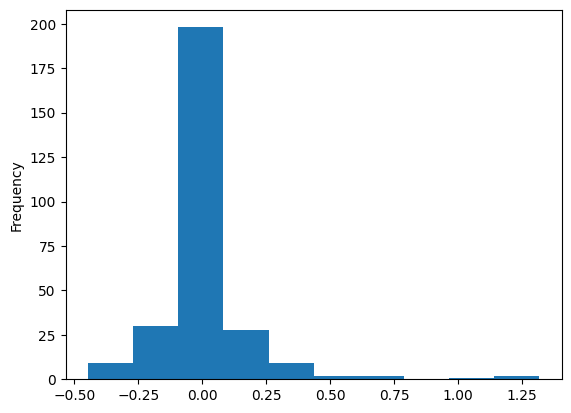

In [135]:
df_combined["USDT_pct_change"].plot.hist()

In [136]:
daily_risk_free_rate = .0494/365 # 1Y T Bill

windows = (1, 3, 5, 7, 10, 14)
thresholds = (-.1, -.05, -.01, 0, .01, .05, .1)

df_sr = []
for window in windows:
    df_sr.append(
        [
            run_strategy(
                starting_capital=100,
                interest_rate_currency="USDT",
                rolling_window=window,
                rate_change_threshold=threshold,
                daily_risk_free_rate=daily_risk_free_rate
            ).sharpe_ratio
            for threshold in thresholds
        ]
    )
df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds)

df_in_market_pct = []
for window in windows:
    df_in_market_pct.append(
        [
            run_strategy(
                starting_capital=100,
                interest_rate_currency="USDT",
                rolling_window=window,
                rate_change_threshold=threshold,
                daily_risk_free_rate=daily_risk_free_rate
            ).days_in_market_pct
            for threshold in thresholds
        ]
    )
df_in_market_pct = pd.DataFrame(df_in_market_pct, index=windows, columns=thresholds)

Text(50.722222222222214, 0.5, 'Rolling Window')

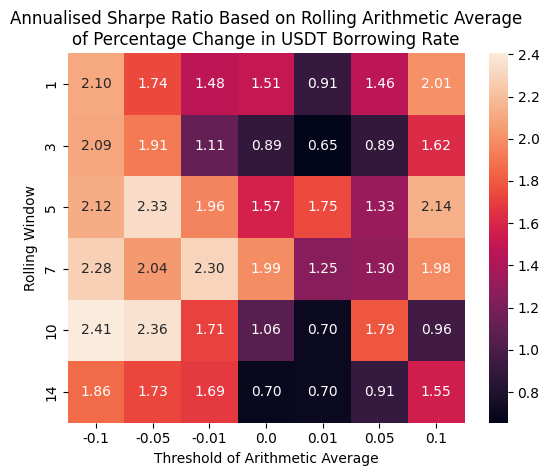

In [146]:
ax = sns.heatmap(df_sr, annot=True, fmt=".2f")
ax.set_title("Annualised Sharpe Ratio Based on Rolling Arithmetic Average\nof Percentage Change in USDT Borrowing Rate")
ax.set_xlabel("Threshold of Arithmetic Average")
ax.set_ylabel("Rolling Window")

Text(50.722222222222214, 0.5, 'Rolling Window')

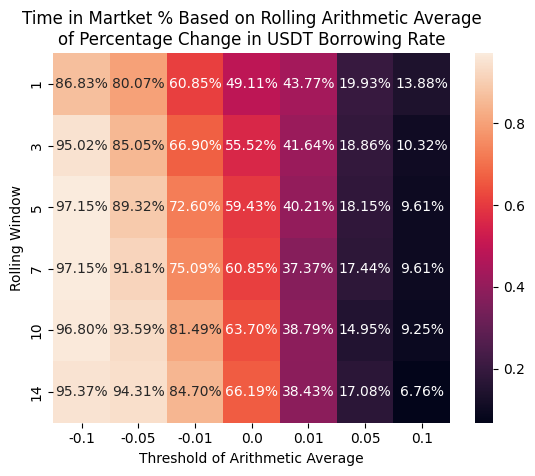

In [147]:
ax = sns.heatmap(df_in_market_pct, annot=True, fmt=".2%")
ax.set_title("Time in Martket % Based on Rolling Arithmetic Average\nof Percentage Change in USDT Borrowing Rate")
ax.set_xlabel("Threshold of Arithmetic Average")
ax.set_ylabel("Rolling Window")

In [133]:
_ = (df_combined["close"].pct_change() - 0.0494/365)
_.mean() * np.sqrt(365) / _.std()

1.8782553457116806